# Fitting Scaling Relationships with ScaleRPy

Created by Bryanne McDonough 12/3/24

In [1]:
%reload_ext autoreload
%autoreload 2   
import ScaleRPy as sr
from ScaleRPy.fitting import fit_funcs
from ScaleRPy.man_dat import SpatGalDat
from ScaleRPy.formatting import *
import numpy as np
import matplotlib.pyplot as plt
from ScaleRPy.formatting import density_contours as dc

In [12]:
#help(sr)
help(sr.fitting)


Help on package ScaleRPy.fitting in ScaleRPy:

NAME
    ScaleRPy.fitting

PACKAGE CONTENTS
    fit_funcs

FILE
    (built-in)




In [2]:
spax = np.load('C:/Users/br.mcdonough/Documents/Projects/ScaleRPy/flatstack.npy')
print(spax.shape)
print(max(spax[3,:]))

(5, 12815387)
3.0


In [3]:
#Create a SpatGalDat object with your spatially-resolved data
ind = spax[3,:]
wh=np.nonzero((ind!=0))
##replace with actual data call for self, for package help doc replace with generic
#converting to float32 is recommended to improve computation time for larger datasets
mass = np.float32(spax[0,:][wh])
sfr = np.float32(spax[1,:][wh])
gas = []
sfr[-1] = np.nan
dat = SpatGalDat(s_mass = mass, sfr = sfr, scale = 'log')
print(dat.sfr)


[-2.3934214 -2.183472  -2.9425154 ... -2.0567467 -5.266341         nan]


In [4]:
#Identify the default units:
print(dat.s_mass_unit)
print(dat.sfr_unit)
#print(dat.gas_unit)

$M_\odot \mathrm{kpc}^{-2}$
$M_\odot \mathrm{yr}^{-1} \mathrm{kpc}^{-2}$


The default units are in written in latex because they will make up the axis of our formal plots. You can update the units manually.

In [5]:
dat.s_mass_unit = r'$M_\odot \mathrm{kpc}^{-2}$'
print(dat.s_mass_unit)

$M_\odot \mathrm{kpc}^{-2}$


In [6]:
#print(vars(dat))
print(dat.parameters['stellar_mass'])
print(dat.parameters['sfr'])

[7.3401527 7.2800536 7.285128  ... 7.5520363 6.5272293 7.607383 ]
[-2.3934214 -2.183472  -2.9425154 ... -2.0567467 -5.266341         nan]


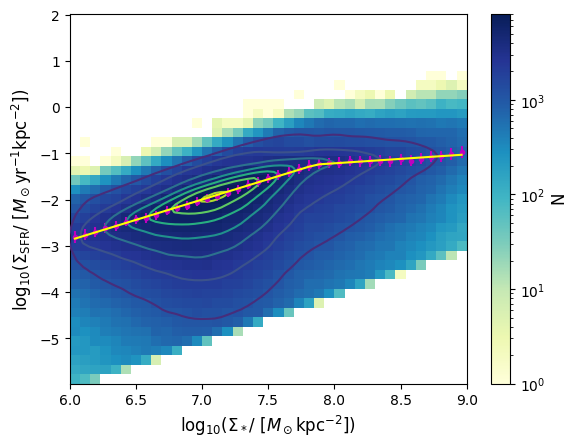

In [7]:
out = dat.SFMS_ridge(xrange=(6,9),fittype='kde', contouring=True)

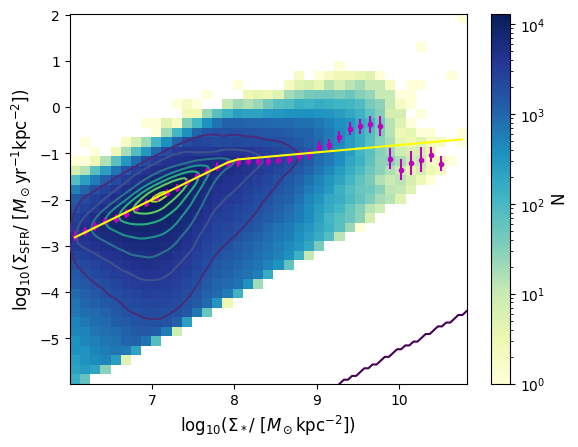

In [8]:
out = dat.SFMS_ridge(fittype='kde')
#how do results depend on number of bins?

#whfinite = np.nonzero((np.isfinite(dat.parameters['stellar_mass'])) & (np.isfinite(dat.parameters['sfr'])))
#dc.density_contour(dat.parameters['stellar_mass'][whfinite], dat.parameters['sfr'][whfinite], out[0][1], zorder=10)

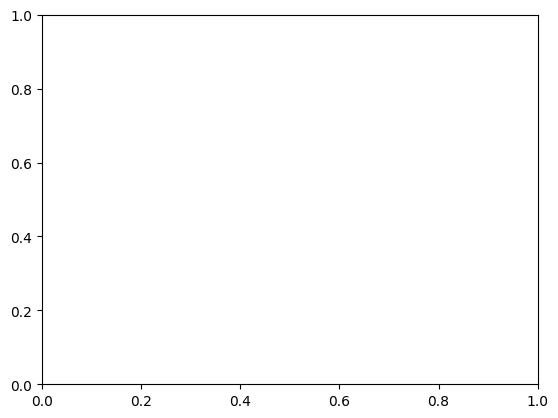

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1)

In [ ]:
#histval = dat.SFMS_histval
#print(histval[-1,:])
xedges = dat.SFMS_xedges
yedges = dat.SFMS_yedges
bin=0

whbin = np.nonzero((mass>xedges[bin]) & (mass<= xedges[bin+1]) & (np.isfinite(sfr)))
plt.hist(sfr[whbin])
print(whbin)

"""
y_c = (yedges[:-1] + yedges[1:]) / 2
print(len(y_c), len(histval[0,:]))
skew_fit, skewerr = fit.fit_gauss(y_c, histval[0,:])#, priors = (-2,0.8,1))
print(skew_fit)

col=histval[0,:]
wh = np.isfinite(col)
col=col[wh][12:18]
y_c = y_c[wh][12:18]
plt.plot(y_c, fit.gauss(y_c,*skew_fit))
#plt.plot(y_c, fit.skew_normal_pdf(y_c,-2.8,0.5,-1))
print(col/simpson(col, x= y_c))
plt.plot(y_c,col/simpson(col, x= y_c), marker='.')
#from scipy.integrate import simpson
#print(simpson(fit.skew_normal_pdf(y_c,-2.8,0.5,-1),x=y_c))
"""


In [ ]:
histval = dat.SFMS_histval
print(histval[-1,:])
yedges = dat.SFMS_yedges
y_c = (yedges[:-1] + yedges[1:]) / 2
print(len(y_c), len(histval[0,:]))
skew_fit, skewerr = fit.fit_skew_norm(y_c, histval[0,:])#, priors = (-2,0.8,1))
print(skew_fit)

col=histval[-1,:]
wh = np.isfinite(col)
col=col[wh]
y_c = y_c[wh]
plt.plot(y_c, fit.skew_normal_pdf(y_c,*skew_fit))
#plt.plot(y_c, fit.skew_normal_pdf(y_c,-2.8,0.5,-1))
print(col/simpson(col, x= y_c))
plt.plot(y_c,col/simpson(col, x= y_c), marker='.')
#from scipy.integrate import simpson
#print(simpson(fit.skew_normal_pdf(y_c,-2.8,0.5,-1),x=y_c))



In [ ]:
hist, ax, ridge = dat.SFMS_ridge(xrange=(6,9.5))
#how do results depend on number of bins?

print(ridge)

#In this case, a smaller xrange will fix the overfitting of points based on less data
#But ideally would have errors on the ridge points
#instead of fitting with Gaussian, skew-normal?

In [ ]:
hist, ax, ridge = dat.SFMS_ridge(xrange=(6,9.5))
#how do results depend on number of bins?
#overwriting SFMS_ridge function
print(ridge)
#left off editing this function to also plot the ridge line
#may want to update the functions used by curvefit to take in one array with the params? 

Next steps: find way to handle quenched spaxels (prefer removing quenched as opposed)
AND have choice to fit histogram columns with a double gaussian

In R&P, highlight MS ridge by multiplying counts by SFR